In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# readd from saas csv
df = pd.read_csv('saas.csv')

In [3]:
# peek
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# peek
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# ensure invoice dates are in datetime format
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])

In [6]:
# set invoice dates as index
df.set_index('Month_Invoiced', inplace=True)

In [7]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


## Split data (train/test) and resample by any period except daily, and aggregate using the sum.

In [8]:
df.index.min()

Timestamp('2014-01-31 00:00:00')

In [9]:
df.index.max()

Timestamp('2017-12-31 00:00:00')

In [10]:
train = df[:'2016'].Amount.resample('W').agg('sum')
test = df['2017':].Amount.resample('W').agg('sum')

In [11]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 201
Training Observations: 153
Testing Observations: 48


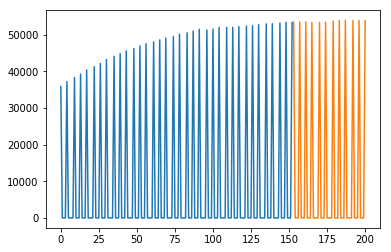

In [12]:
plt.plot(train.values)
plt.plot([None for i in train.values] + [x for x in test.values])
plt.show()

In [13]:
# series = df.Amount.resample('M').agg('sum')
# X = series.values

In [14]:
# train_size = int(len(X) * 0.7)
# train, test = X[0:train_size], X[train_size:len(X)]

In [15]:
# print('Observations: %d' % (len(X)))
# print('Training Observations: %d' % (len(train)))
# print('Testing Observations: %d' % (len(test)))

In [16]:
# plt.plot(train)
# plt.plot([None for i in train] + [x for x in test])
# plt.show()

## Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
## simple average

In [17]:
yhat = pd.DataFrame(dict(actual=test))

In [18]:
yhat['avg_forecast'] = train.mean()

In [19]:
yhat.head()

,actual,avg_forecast
Month_Invoiced,,
2017-02-05,53395.0,11274.509804
2017-02-12,0.0,11274.509804
2017-02-19,0.0,11274.509804
2017-02-26,0.0,11274.509804
2017-03-05,53440.0,11274.509804


In [20]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

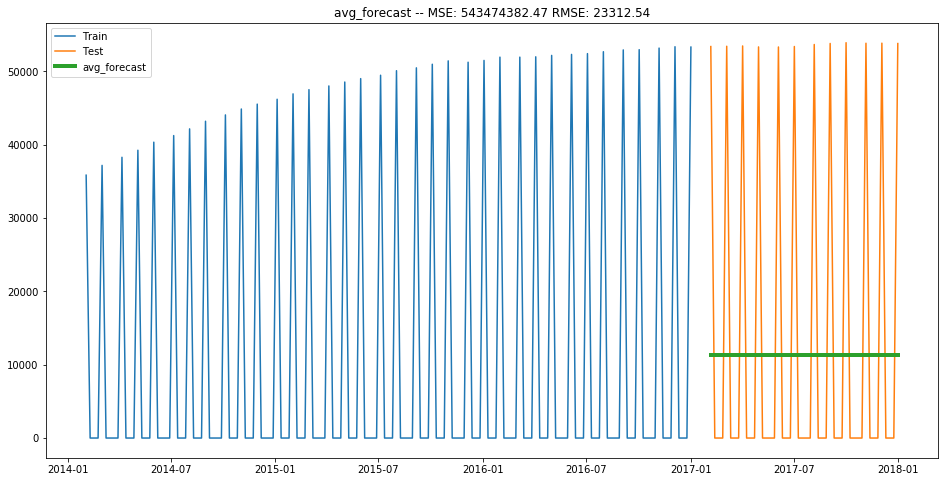

In [21]:
plot_and_eval(yhat.avg_forecast)

## moving average

In [69]:
periods = 50
yhat['moving_avg_forecast_50'] = train.rolling(50).mean().iloc[-1]

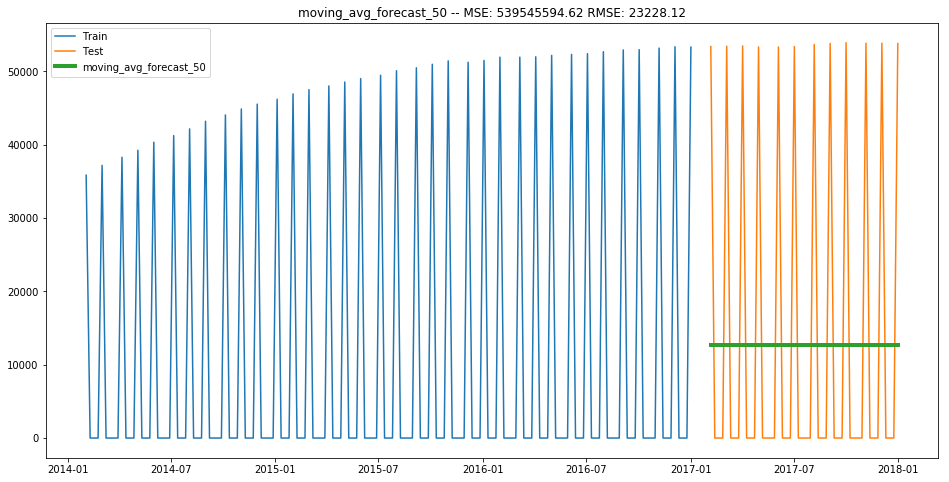

In [70]:
 plot_and_eval(yhat.moving_avg_forecast_50)

## Holt's linear trend model
## Based on previous year/month/etc (your choice)

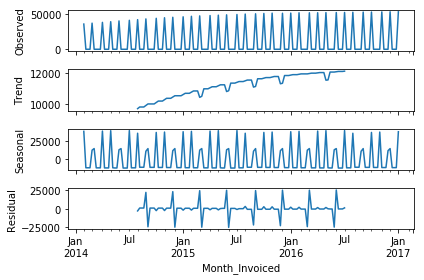

In [24]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [25]:
holt = Holt(train).fit(smoothing_level=.1, smoothing_slope=.1)

In [65]:
yhat['holt_linear'] = holt.forecast(test.shape[0]+4)

In [64]:
yhat

,actual,avg_forecast,moving_avg_forecast_50,holt_linear,last_year
Month_Invoiced,,,,,
2017-02-05,53395.0,11274.509804,12627.1,16084.702103,0.0
2017-02-12,0.0,11274.509804,12627.1,16365.422558,51955.0
2017-02-19,0.0,11274.509804,12627.1,16646.143013,0.0
2017-02-26,0.0,11274.509804,12627.1,16926.863468,0.0
2017-03-05,53440.0,11274.509804,12627.1,17207.583924,0.0
2017-03-12,0.0,11274.509804,12627.1,17488.304379,0.0
2017-03-19,0.0,11274.509804,12627.1,17769.024834,51955.0
2017-03-26,0.0,11274.509804,12627.1,18049.745289,0.0
2017-04-02,53480.0,11274.509804,12627.1,18330.465744,0.0


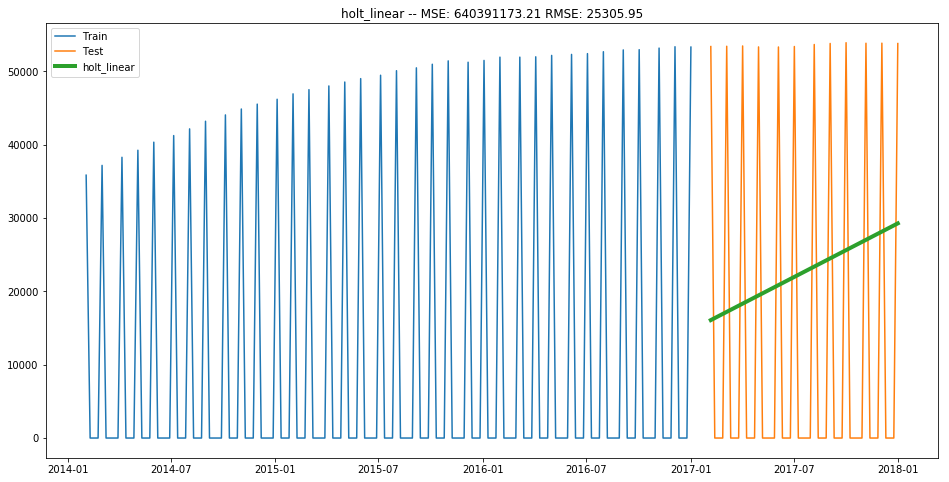

In [66]:
plot_and_eval(yhat.holt_linear)

In [35]:
train['2016'].index

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28', '2016-03-06', '2016-03-13', '2016-03-20',
               '2016-03-27', '2016-04-03', '2016-04-10', '2016-04-17',
               '2016-04-24', '2016-05-01', '2016-05-08', '2016-05-15',
               '2016-05-22', '2016-05-29', '2016-06-05', '2016-06-12',
               '2016-06-19', '2016-06-26', '2016-07-03', '2016-07-10',
               '2016-07-17', '2016-07-24', '2016-07-31', '2016-08-07',
               '2016-08-14', '2016-08-21', '2016-08-28', '2016-09-04',
               '2016-09-11', '2016-09-18', '2016-09-25', '2016-10-02',
               '2016-10-09', '2016-10-16', '2016-10-23', '2016-10-30',
               '2016-11-06', '2016-11-13', '2016-11-20', '2016-11-27',
               '2016-12-04', '2016-12-11', '2016-12-18', '2016-12-25'],
              dtype='datetime64[ns]', name='Month_Invoiced', freq='W-SUN')

In [37]:
train['2016'].index+52

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05', '2017-03-12', '2017-03-19',
               '2017-03-26', '2017-04-02', '2017-04-09', '2017-04-16',
               '2017-04-23', '2017-04-30', '2017-05-07', '2017-05-14',
               '2017-05-21', '2017-05-28', '2017-06-04', '2017-06-11',
               '2017-06-18', '2017-06-25', '2017-07-02', '2017-07-09',
               '2017-07-16', '2017-07-23', '2017-07-30', '2017-08-06',
               '2017-08-13', '2017-08-20', '2017-08-27', '2017-09-03',
               '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01',
               '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29',
               '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26',
               '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24'],
              dtype='datetime64[ns]', name='Month_Invoiced', freq='W-SUN')

In [53]:
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='Month_Invoiced')\
    .set_index(train['2016'].index + 54)\
    .iloc[:-1]

In [54]:
yhat['last_year'] = using_last_year

In [55]:
yhat

,actual,avg_forecast,moving_avg_forecast_50,holt_linear,last_year
Month_Invoiced,,,,,
2017-02-05,53395.0,11274.509804,12627.1,16084.702103,0.0
2017-02-12,0.0,11274.509804,12627.1,16365.422558,51955.0
2017-02-19,0.0,11274.509804,12627.1,16646.143013,0.0
2017-02-26,0.0,11274.509804,12627.1,16926.863468,0.0
2017-03-05,53440.0,11274.509804,12627.1,17207.583924,0.0
2017-03-12,0.0,11274.509804,12627.1,17488.304379,0.0
2017-03-19,0.0,11274.509804,12627.1,17769.024834,51955.0
2017-03-26,0.0,11274.509804,12627.1,18049.745289,0.0
2017-04-02,53480.0,11274.509804,12627.1,18330.465744,0.0


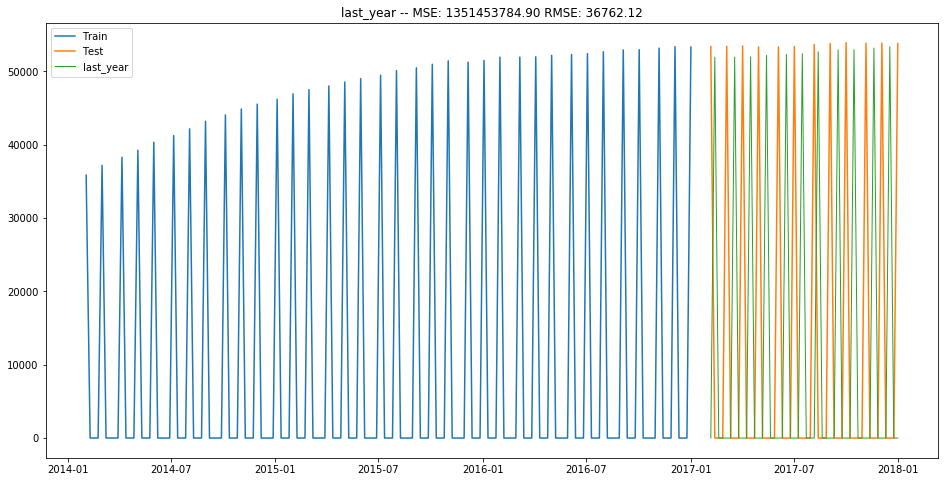

In [56]:
plot_and_eval(yhat.last_year, linewidth=1)

Using mall customer data
Predict 2018 total monthly sales for store 1 by creating a model using prophet
Predict 2018 total monthly sales for each store by creating a model for each store using prophet.
Return a data frame with the month, storeid, yhat, and the confidence intervals (yhat lower, yhat upper)
Plot the 2018 monthly sales predictions for each store to compare predicted performance. (e.g. line chart where each line represents store id (color), x is the month, y is sales)

In [121]:
from fbprophet import Prophet
from acquire_mall import *
from prepare_mall import *
import acquire
import prepare

In [122]:
dfm = get_mall_data()

In [123]:
dfm.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [124]:
dfm = prep_mall_data(dfm)

In [152]:
df = acquire.get_all_stuff()

In [153]:
# df = prepare.to_datetime_utc(df)

In [154]:
# df = prepare.make_cols(df)

In [155]:
df = prepare.make_new_sales_amounts(df)

In [144]:
# prepare.re_index_by_time(df)

In [156]:
d_df = df[df['store_id']==2]

In [ ]:
# df.resample('M').agg(sum) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [157]:
d_df['y'] = d_df.sales_total

In [158]:
d_df.head()

,item_id,quantity,sale_date,sale_id,store_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14,sales_total,y
1826,1,12.0,"Tue, 01 Jan 2013 00:00:00 GMT",1827,2,9255 FM 471 West,San Antonio,TX,78251,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,10.08,10.08
1827,1,16.0,"Wed, 02 Jan 2013 00:00:00 GMT",1828,2,9255 FM 471 West,San Antonio,TX,78251,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,13.44,13.44
1828,1,16.0,"Thu, 03 Jan 2013 00:00:00 GMT",1829,2,9255 FM 471 West,San Antonio,TX,78251,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,13.44,13.44
1829,1,20.0,"Fri, 04 Jan 2013 00:00:00 GMT",1830,2,9255 FM 471 West,San Antonio,TX,78251,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,16.80,16.80
1830,1,16.0,"Sat, 05 Jan 2013 00:00:00 GMT",1831,2,9255 FM 471 West,San Antonio,TX,78251,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,13.44,13.44


In [159]:
d_df['ds'] = pd.to_datetime(d_df.sale_date)

In [160]:
d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

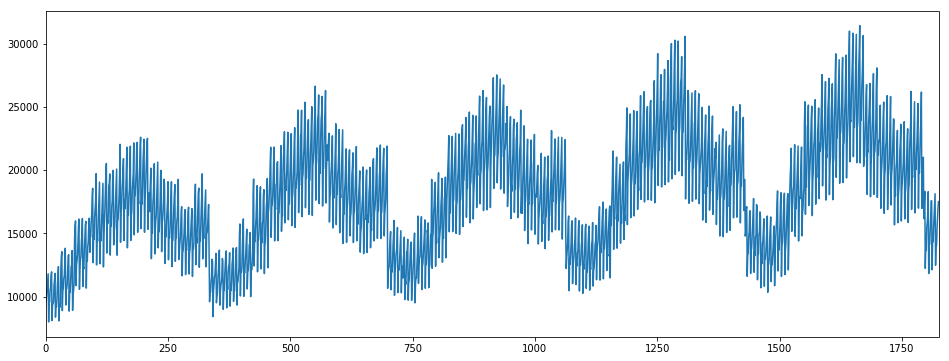

In [161]:
plt.figure(figsize=(16,6))
sns.tsplot(d_df.y)

In [162]:
d_df.y.min()

7992.189999999999

In [163]:
d_df.head()

,ds,y
0,2013-01-01,9554.44
1,2013-01-02,9696.05
2,2013-01-03,10250.73
3,2013-01-04,10784.40
4,2013-01-05,11362.45


In [175]:
d_df['cap'] = 35000
d_df['floor'] = 8000
# d_df.ds = d_df.ds.tz_localize('UTC')
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9)
m.fit(d_df)



In [176]:
future = m.make_future_dataframe(periods=52)
future['cap'] = 35000
future['floor'] = 8000
print(future.head())
print(future.tail())
print(d_df.tail())

          ds    cap  floor
0 2013-01-01  35000   8000
1 2013-01-02  35000   8000
2 2013-01-03  35000   8000
3 2013-01-04  35000   8000
4 2013-01-05  35000   8000
             ds    cap  floor
1873 2018-02-17  35000   8000
1874 2018-02-18  35000   8000
1875 2018-02-19  35000   8000
1876 2018-02-20  35000   8000
1877 2018-02-21  35000   8000
             ds         y    cap  floor
1821 2017-12-27  14028.73  35000   8000
1822 2017-12-28  15384.19  35000   8000
1823 2017-12-29  16294.41  35000   8000
1824 2017-12-30  17022.91  35000   8000
1825 2017-12-31  17521.46  35000   8000


In [177]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1873,2018-02-17,19442.613236,18265.086308,20563.410677
1874,2018-02-18,20725.173979,19484.257049,21905.676345
1875,2018-02-19,13664.977515,12460.889673,14790.439631
1876,2018-02-20,16103.591592,14960.861713,17250.638651
1877,2018-02-21,16242.390771,15038.060327,17411.566394


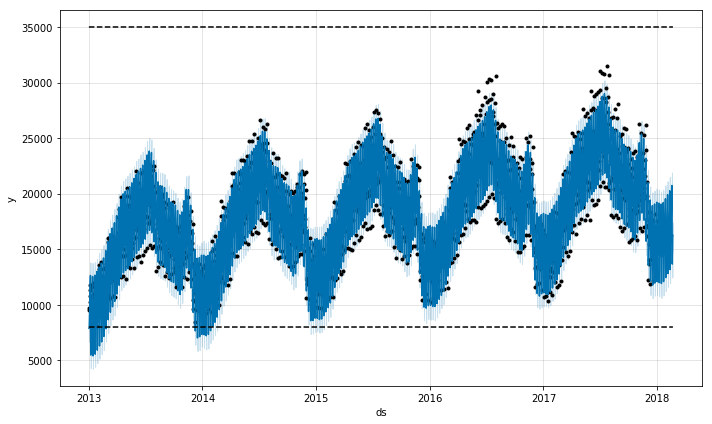

In [178]:
fig1 = m.plot(forecast)

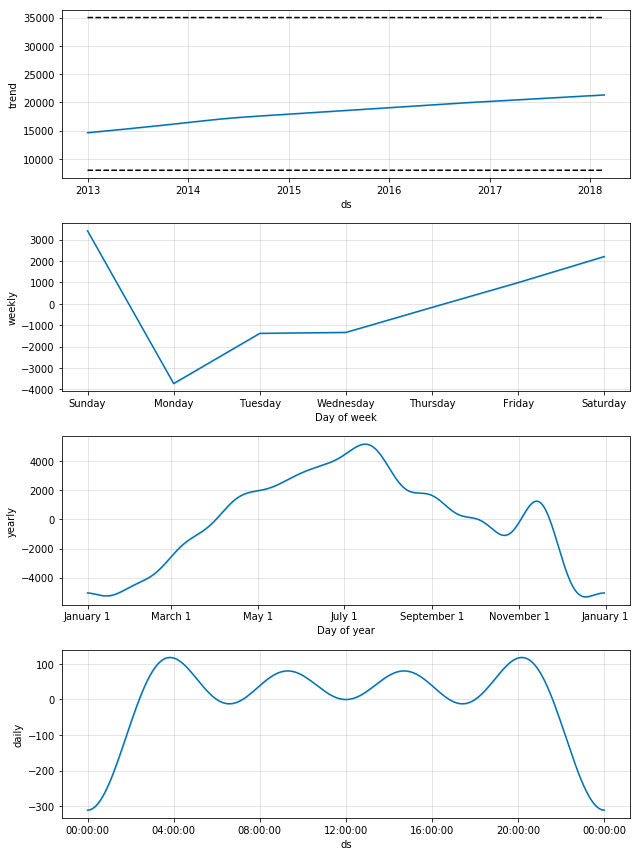

In [179]:
fig2 = m.plot_components(forecast)

In [180]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [181]:
df_cv = cross_validation(m, horizon=, period='w')


ValueError: unit abbreviation w/o a number